In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

shl_intern_hiring_assessment_path = kagglehub.competition_download('shl-intern-hiring-assessment')

print('Data source import complete.')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
df_scores = pd.read_csv("/kaggle/input/shl-intern-hiring-assessment/dataset/train.csv")
train_df, val_df = train_test_split(df_scores, test_size=0.4, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print("Train size:", len(train_df))
print("Val size:", len(val_df))
train_df.head()

Train size: 266
Val size: 178


,filename,label
0,audio_188.wav,4.5
1,audio_493.wav,5.0
2,audio_868.wav,2.0
3,audio_934.wav,2.0
4,audio_74.wav,5.0


In [ ]:
!pip install librosa --quiet

In [ ]:
import librosa
import numpy as np

def extract_features(file_path, sr=22050):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=60)  # Limit to 30s if needed
        features = []

        # MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        features.extend(np.mean(mfccs, axis=1))

        # Chroma
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features.extend(np.mean(chroma, axis=1))

        # Spectral Contrast
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        features.extend(np.mean(contrast, axis=1))

        # Zero-crossing rate
        zcr = librosa.feature.zero_crossing_rate(y)
        features.append(np.mean(zcr))

        # RMS energy
        rms = librosa.feature.rms(y=y)
        features.append(np.mean(rms))

        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return [0]*21  # fallback in case of error


In [ ]:
import os
from tqdm import tqdm

AUDIO_DIR = "/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train"

def generate_feature_df(df,audio_dir):
    feature_list = []
    for fname in tqdm(df['filename']):
        file_path = os.path.join(AUDIO_DIR, fname)
        features = extract_features(file_path)
        feature_list.append(features)

    features_df = pd.DataFrame(feature_list)
    features_df.columns = [f'feature_{i}' for i in range(features_df.shape[1])]
    return features_df


In [ ]:
X_train = generate_feature_df(train_df,AUDIO_DIR)
y_train = train_df['label'].values

X_val = generate_feature_df(val_df,AUDIO_DIR)
y_val = val_df['label'].values


100%|██████████| 178/178 [02:06<00:00,  1.41it/s]


In [ ]:
import os
import shutil

original_audio_dir = "/kaggle/input/shl-intern-hiring-assessment/dataset/audios_train"
train_audio_dir = "/kaggle/working/audios_train"
val_audio_dir = "/kaggle/working/audios_val"
os.makedirs(train_audio_dir, exist_ok=True)
os.makedirs(val_audio_dir, exist_ok=True)
for fname in train_df["filename"]:
    src = os.path.join(original_audio_dir, fname)
    dst = os.path.join(train_audio_dir, fname)
    shutil.copy2(src, dst)
for fname in val_df["filename"]:
    src = os.path.join(original_audio_dir, fname)
    dst = os.path.join(val_audio_dir, fname)
    shutil.copy2(src, dst)


In [ ]:
!pip install xgboost


In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print("Validation MSE:", mse)


Validation MSE: 0.915453399337885


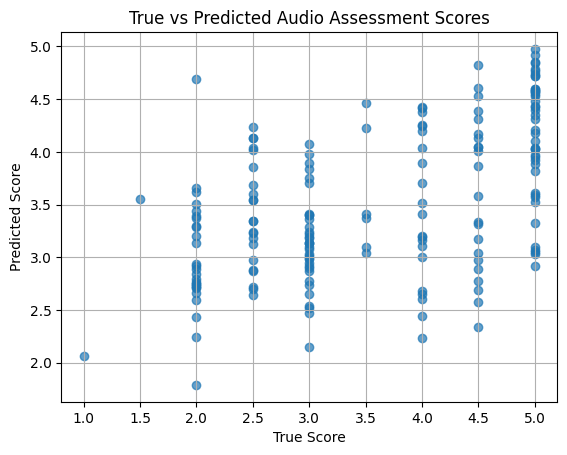

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_val, y_pred, alpha=0.7)
plt.xlabel("True Score")
plt.ylabel("Predicted Score")
plt.title("True vs Predicted Audio Assessment Scores")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

test_df = pd.read_csv("/kaggle/input/shl-intern-hiring-assessment/dataset/test.csv")  # update path if needed
test_df.head()

,filename
0,audio_706.wav
1,audio_800.wav
2,audio_68.wav
3,audio_1267.wav
4,audio_683.wav


In [ ]:
import os

TEST_AUDIO_DIR = "/kaggle/input/shl-intern-hiring-assessment/dataset/audios_test"
test_files = [f for f in os.listdir(TEST_AUDIO_DIR) if f.endswith(".wav")]
print(test_files[:5])

['audio_885.wav', 'audio_698.wav', 'audio_1176.wav', 'audio_1215.wav', 'audio_66.wav']


In [ ]:
test_df = pd.DataFrame({'filename': test_files})

In [ ]:

X_test = generate_feature_df(test_df,TEST_AUDIO_DIR)

100%|██████████| 195/195 [02:24<00:00,  1.35it/s]


In [ ]:
predictions = model.predict(X_test)
test_df['predicted_score'] = predictions

In [ ]:
test_df.to_csv("test.csv", index=False)